# Predicción de la demanda energica diaria en California

**Caso a estudiar**: Estudiaremos la demanda energica en California, establecida en una frecuencia diaria, para obtener una predicción de los **15 primeros días de diciembre 2021**.

California es el estado con el mercado mas grande de los Estados Unidos, cuenta con un PIB de 2.656.080 millones de dolares, y una producción de energía de 1.844.000 millones de megawatts.

El PIB de California representa el 14% del PIB de los Estados Unidos, y el PIB de los Estados Unidos representa el 24% mundial.


### Importamos librerias

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from numpy import log

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sktime.utils.plotting import plot_series
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error

from kats.models.prophet import Prophet

Importamos los datos y nos quedamos con los datos necesarios para el análisis.

In [71]:
df_demand = pd.read_excel('DemandaEnergia.xlsx', sheet_name='Daily_Data')
df_day = df_demand.drop(['Region', 'Time zone'], axis=1)

df_day.rename(columns={'D': 'Demand', 'Local date': 'Local_date'}, inplace=True)
df_day.set_index('Local_date', inplace=True)

df_day.index = pd.PeriodIndex(df_day.index, freq='D')
df_day

,Demand
Local_date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


Text(0.5, 1.0, 'Demanda electrica por dia')

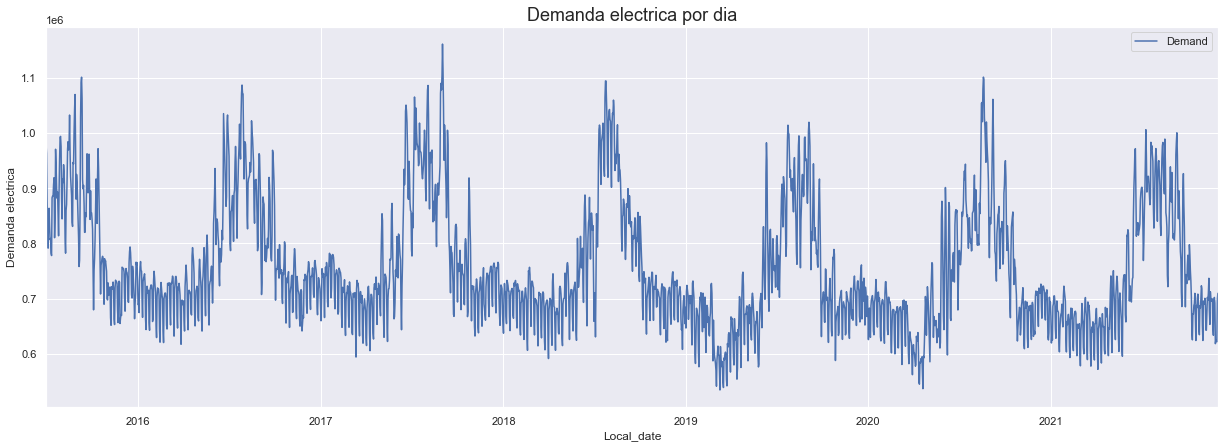

In [72]:
sns.set(rc={'figure.figsize':(21, 7)})
ax = df_day.plot(linestyle='-')
ax.set_ylabel('Demanda electrica')
ax.set_title('Demanda electrica por dia', fontsize=18)

Podemos apreciar que la serie tiene pendiente constante pero estacionalidad aditiva.

## EDA: Análisis exploratorio de los datos

Graficamos la serie recortada que utilizaremos para el modelado para ver como se comporta.

Text(0.5, 1.0, 'Demanda electrica por dia')

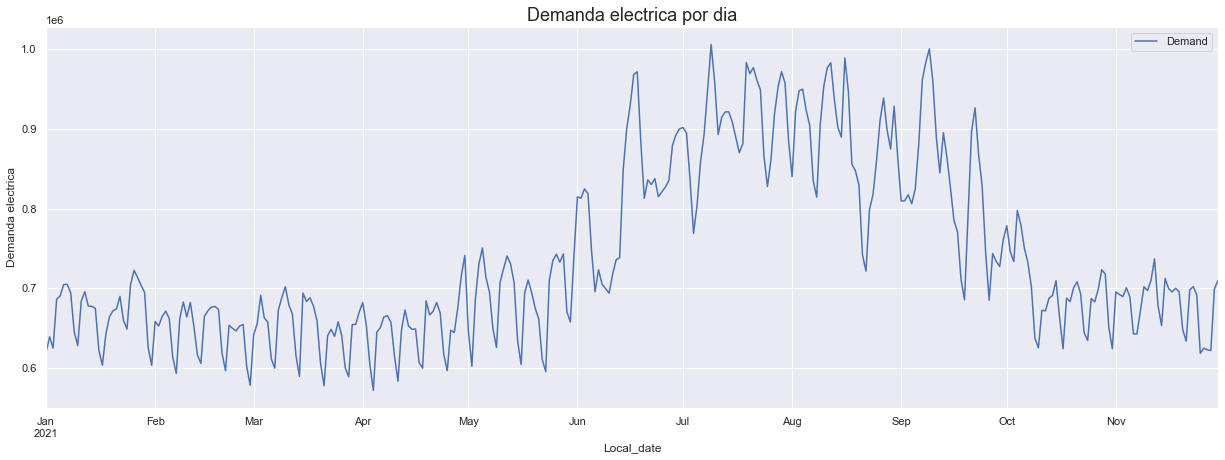

In [73]:
sns.set(rc={'figure.figsize':(21, 7)})
ax = df_day['2021-01-01':].plot(linestyle='-')
ax.set_ylabel('Demanda electrica')
ax.set_title('Demanda electrica por dia', fontsize=18)

Ahora vamos a ver como se comporta la serie en diferentes periodos de tiempo, 

Text(0.5, 0.98, '')

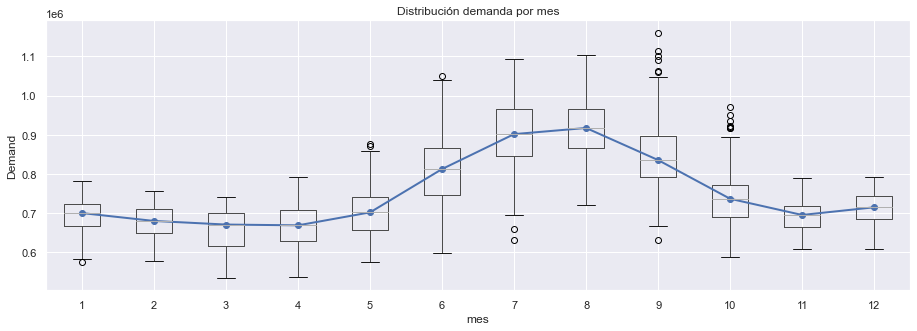

In [74]:
boxplots = df_day.copy()

fig, ax = plt.subplots(figsize=(15, 5))
boxplots['mes'] = boxplots.index.month
boxplots.boxplot(column='Demand', by='mes', ax=ax,)
boxplots.groupby('mes')['Demand'].median().plot(style='o-', linewidth=2, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('')

Observamos que hay un aumento de la demanda en los meses de verano que tiene su pico en el mes de agosto, en cuanto llegan los meses de frio se vuelve a disminuir la demanda es decir, de octubre a mayo.

Text(0.5, 0.98, '')

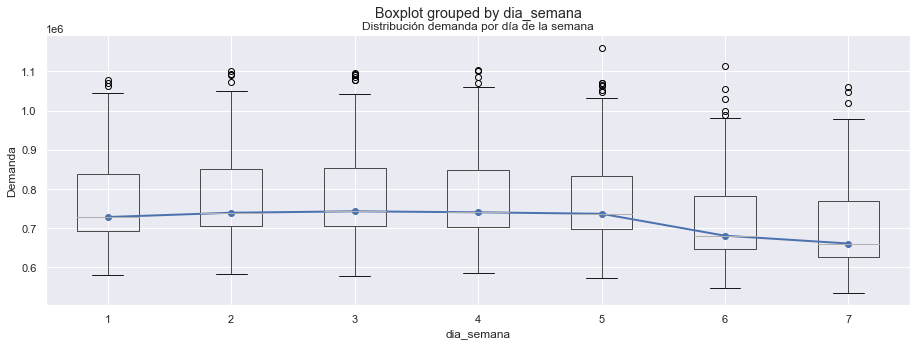

In [75]:
Ufig, ax = plt.subplots(figsize=(15, 5))
boxplots['dia_semana'] = boxplots.index.day_of_week + 1
boxplots.boxplot(column='Demand', by='dia_semana', ax=ax)
boxplots.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=2, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('')

### Estacionariedad (Dickey-Fuller)

Usamos la prueba de Dickey-Fuller que nos proporciona una verificación rápida y evidente de si la serie es estacional o no.

**La hipótesis nula** (**H0**) de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria (tiene alguna estructura dependiente del tiempo). **La hipótesis alternativa** (**H1**) (rechazando la hipótesis nula) es que la serie de tiempo es estacionaria.

Interpretamos este resultado utilizando el **p-value**. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza. 

In [76]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_day)

Results of Dickey-Fuller Test:
Test Statistic                   -3.353586
p-value                           0.012647
#Lags Used                       27.000000
Number of Observations Used    2317.000000
Critical Value (1%)              -3.433175
Critical Value (5%)              -2.862788
Critical Value (10%)             -2.567434
dtype: float64


La serie temporal es estacionaria, debido a que el p-value del test Dickey-Fuller es menor que 0.05. **Rechazamos la hipotesis nula (H0)**.

Vemos que nuestro test estadistico (-3.3535) es menor que el umbral de significancia 5% (-2.86), sin embargo está un poco por encima del umbral de significacncia del 1% (-3.43). 

Esto sugiere que podemos rechazar la hipótesis nula con baja probabilidad de que el resultado sea una casualidad estadistica.

Ahora comprobaremos si hay datos duplicados o si hay datos nulos.

In [77]:
print(df_day.duplicated().sum())
print(df_day.isnull().sum())

7
Demand    0
dtype: int64


## Modelado

### Separamos la serie en train y test

Haremos una evaluacion de los posibles modelos a utilizar mediante muestras de entrenamiento y prueba, para comprobar qué módelo es el que mejor predice nuestro set de prueba. Una vez escojamos el modelo con mejores resultados, haremos la predicción de los 15 dias de Diciembre.

El periodo de entrenamiento tendrá una longitud de 1 año aproximado, desde el dia 1 de enero hasta el dia 31 de octubre, 10 meses. Sin embargo, el periodo de prueba será de 1 mes, el de noviembre,  un 10% de la longitud de la serie de entrenamiento.

304 30


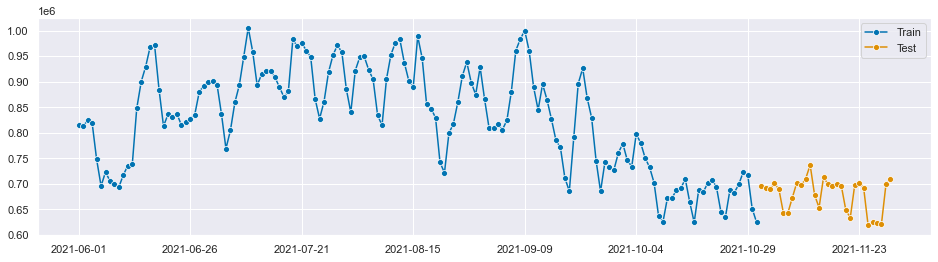

In [78]:
period_train = df_day.loc['2021-01-01':]

# Select Train & test samples
y_train, y_test = temporal_train_test_split(y=period_train, test_size=30)

plot_series(y_train['2021-06-01':], y_test, labels=["Train", "Test"])
# Time Series Size
print(y_train.shape[0], y_test.shape[0])

### Modelo base ingenuo (Naïve) estacional

Uno de los modelos mas simples y mas importantes en el pronostico de series temporales es del Random Walk. Supone que para cada periodo la variable dará un paso aleatorio y los pasos se distribuyen de forma independiente e identica. En otras palabras, predice que todos los valores serán iguales a la última observación. 

Este sería el metodo Naive ingenuo, sin embargo nuestra serie temporal tiene un componente estacional, por lo que usaremos un modelo parecido añadiendole la estacionalidad dictada por la serie. Por lo tanto, en vez de predecir el ultimo valor observado, replicará la última estación observada. 

En nuestro caso, tenemos una serie diaria que para cada nuevo periodo, replicará el valor del último día.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

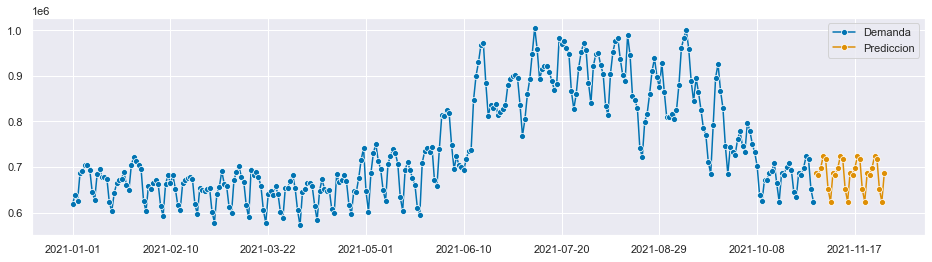

In [79]:
from sktime.forecasting.naive import NaiveForecaster

fh_naive = np.arange(1, 30)
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_naive)
plot_series(y_train, y_pred, labels=['Demanda', 'Prediccion'])

### Modelo ETS

In [80]:
# Forecast Horizon
fh = np.arange(len(y_test)) + 1 # forecasting horizon
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

Empleamos la prediccion del modelo ETS con los datos de train y test sin logaritmos.

In [81]:
# specifying the forecasting algorithm
autoETS_model = AutoETS(auto=True, sp=7, seasonal='add', n_jobs=-1)

In [82]:
#  Auto ETS Model Estimation
autoETS_model.fit(y_train.astype('float64'))

AutoETS(auto=True, n_jobs=-1, seasonal='add', sp=7)

In [83]:
#  Auto ETS Model Summary
print(autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  304
Model:                       ETS(MNM)   Log Likelihood               -3484.206
Date:                Fri, 21 Jan 2022   AIC                           6990.411
Time:                        13:41:07   BIC                           7031.298
Sample:                    01-01-2021   HQIC                          7006.767
                         - 10-31-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.046     21.890      0.000       0.910       1.089
smoothing_seasonal  1.002e-05        nan        nan        nan         nan         nan
initial_level       

In [84]:
#  Auto ETS Forecasting
ETS_pred = autoETS_model.predict(fh)

Observamos la prediccion que nos ha arrojado el modelo ETS comparandola con los datos reales de Noviembre.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

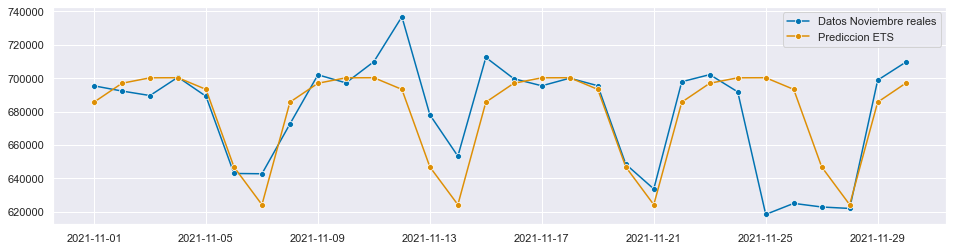

In [85]:
plot_series(y_test, ETS_pred, labels=["Datos Noviembre reales", "Prediccion ETS"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

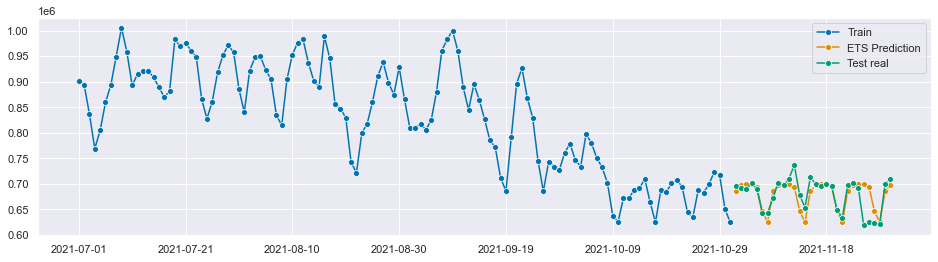

In [86]:
plot_series(y_train['2021-07-01':], ETS_pred, y_test, labels=["Train", "ETS Prediction", "Test real"])

Ahora calculamos los errores del modelo ETS que luego compararemos con los de los siguientes modelos para saber cual elegir como modelo final.

In [87]:
# Forecast Accuracy
# MAPE
ETS_mape = mean_absolute_percentage_error(y_test, ETS_pred)
ETS_mape

0.022964951392300804

In [88]:
# Forecast Accuracy
# Mean Squared Error
rmse = MeanSquaredError(square_root=True)
ETS_rmse = rmse(y_test, ETS_pred)
ETS_rmse

24475.76972336511

### Modelo ARIMA

Usamos el set de train y test con la transformacion logaritmica. La transformacion logaritmica reduce la varianza a largo plazo.

In [89]:
# Auto ARIMA Model

autoARIMA_model = AutoARIMA(sp=7, suppress_warnings=True)
autoARIMA_model.fit(y_train)

AutoARIMA(sp=7, suppress_warnings=True)

In [90]:
print(autoARIMA_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  304
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3543.704
Date:                             Fri, 21 Jan 2022   AIC                           7105.407
Time:                                     13:41:49   BIC                           7138.831
Sample:                                          0   HQIC                          7118.779
                                             - 304                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8074      0.116     15.549      0.000       1.580       2.035
ar.L2         -1.2640      

In [91]:
# Auto ARIMA Forecast
Arima_pred = autoARIMA_model.predict(fh)
Arima_pred.head()

,Demand
2021-11-01,672408.140771
2021-11-02,677809.558478
2021-11-03,677670.955970
2021-11-04,679097.409696
2021-11-05,677608.840235


In [92]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

mean_absolute_percentage_error(y_test, Arima_pred)

0.0358680637427446

In [93]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, Arima_pred)

28295.02988995121

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

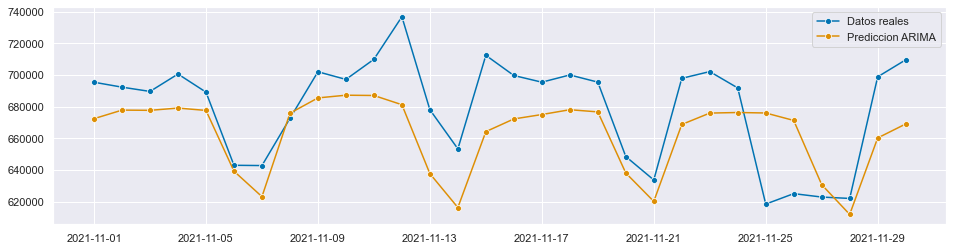

In [94]:
plot_series(y_test, Arima_pred, labels=["Datos reales", "Prediccion ARIMA"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

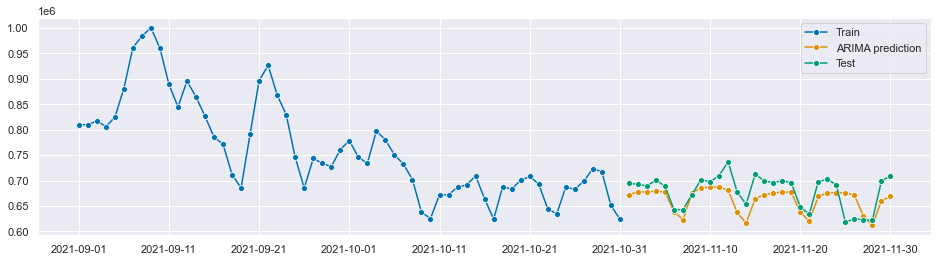

In [95]:
plot_series(y_train["2021-09":], Arima_pred, y_test, labels=["Train", "ARIMA prediction", "Test"])

Graficamos las 2 predicciones anteriores junto con el test para ver la diferencia entre ambas respecto a los datos reales.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

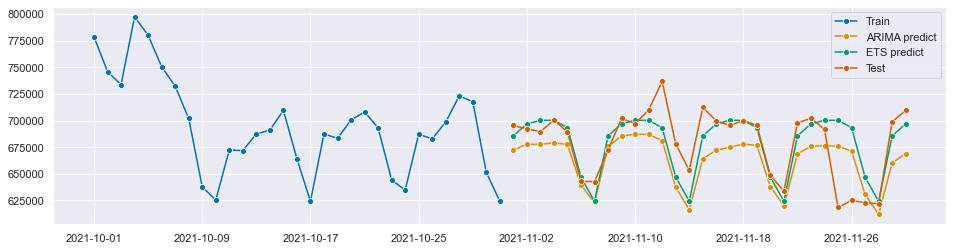

In [96]:
plot_series(y_train["2021-10":], Arima_pred, ETS_pred, y_test, labels=["Train", "ARIMA predict", "ETS predict", "Test"])



Basado en un modelo aditivo donde las tendencias no lineales son ajustadas anualmente semanalmente y diariamente para ver la estacionalidad.

Funciona muy bien con series temporales con efectos estacionales, maneja muy bien los outliers.

### Modelo Prophet

Basado en un modelo aditivo donde las tendencias no lineales son ajustadas anualmente semanalmente y diariamente para ver la estacionalidad. Funciona muy bien con series temporales con efectos estacionales, maneja muy bien los outliers.

Preparamos los datos en el formato que necesita el modelo Prophet.

In [97]:
# Train 
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'D')

In [98]:
# Test
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'D')
len(prophet_y_test)

30

In [99]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False)
m.fit(prophet_y_train)

In [100]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='D')
prophet_forecast = m.predict(m_pred)

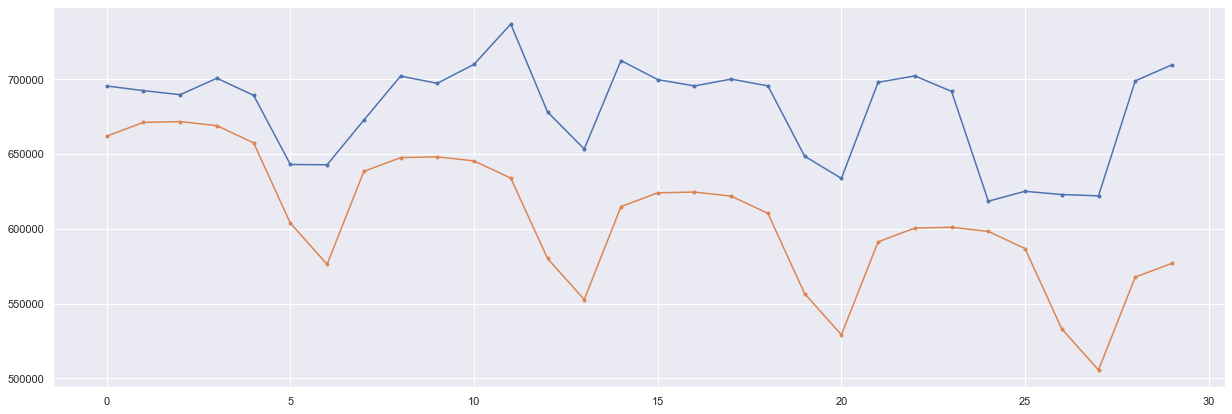

In [101]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[304:, 'yhat']), '.-', label='Predicition')
plt.show()

In [102]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
329,2021-11-26,586764.214096,528043.289299,643636.351488
330,2021-11-27,533118.625576,479726.939511,590016.077733
331,2021-11-28,505640.780100,450914.006398,561913.454673
332,2021-11-29,567742.190140,510814.574230,626171.674219
333,2021-11-30,576950.939817,526988.964675,631157.272668


In [103]:
# Forecast Accuracy
# MAPE
MAPE_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[304:, 'yhat'])
MAPE_prophet

0.11430760546807348

In [104]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse_prophet = rmse(prophet_y_test['y'], prophet_forecast.loc[304:, 'yhat'])
rmse_prophet

80017.72504856811

## Comparacion de modelos

In [105]:
comparacion = {'Errores': ['MAPE','% MAPE', 'RMSE'],
               'ETS': ['0.02297','2.297%', '24475.769'],
               'ARIMA': ['0.05418','5.418%', '40747.791'],
               'Prophet': ['0.11430','11.430%', '80017.725']}

df_comparacion = pd.DataFrame(comparacion)
df_comparacion

,Errores,ETS,ARIMA,Prophet
0,MAPE,0.02297,0.05418,0.11430
1,% MAPE,2.297%,5.418%,11.430%
2,RMSE,24475.769,40747.791,80017.725


## Eleccion del modelo

Nos quedamos con el modelo ETS porque tiene menor error que los otros dos Arima y Prophet.

In [106]:
# Forecast Horizon
fh_pred = np.arange(len(y_test)/2) + 31 # forecasting horizon
fh_pred

array([31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45.])

In [107]:
# specifying the forecasting algorithm
autoETS_predict = AutoETS(auto=True, sp=7, n_jobs=-1)

In [108]:
#  Auto ETS Model Estimation
autoETS_predict.fit(y_train.astype('float64'))

AutoETS(auto=True, n_jobs=-1, sp=7)

In [109]:
#  Auto ETS Model Summary
print(autoETS_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  304
Model:                       ETS(MNM)   Log Likelihood               -3484.206
Date:                Fri, 21 Jan 2022   AIC                           6990.411
Time:                        13:41:52   BIC                           7031.298
Sample:                    01-01-2021   HQIC                          7006.767
                         - 10-31-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.046     21.890      0.000       0.910       1.089
smoothing_seasonal  1.002e-05        nan        nan        nan         nan         nan
initial_level       

In [110]:
#  Auto ETS Forecasting
ETS_predict = autoETS_predict.predict(fh_pred)
print(ETS_predict)

                   Demand
2021-12-01  700232.520267
2021-12-02  700284.341911
2021-12-03  693305.465141
2021-12-04  646858.732613
2021-12-05  624261.391231
2021-12-06  685653.618963
2021-12-07  696971.011238
2021-12-08  700232.520267
2021-12-09  700284.341911
2021-12-10  693305.465141
2021-12-11  646858.732613
2021-12-12  624261.391231
2021-12-13  685653.618963
2021-12-14  696971.011238
2021-12-15  700232.520267


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

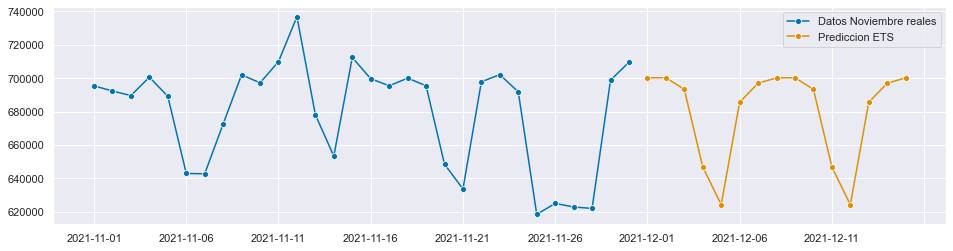

In [111]:
plot_series(y_test, ETS_predict, labels=["Datos Noviembre reales", "Prediccion ETS"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

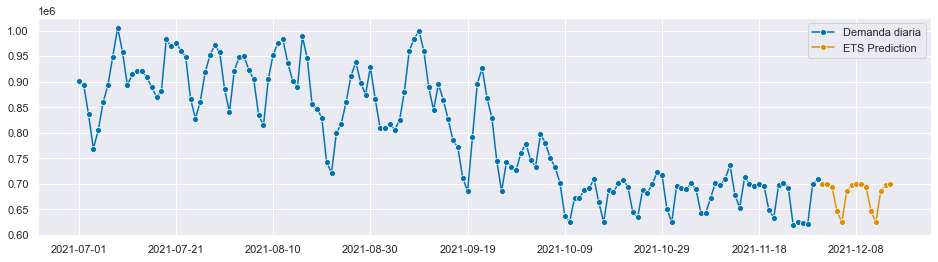

In [112]:
plot_series(df_day['2021-07-01':], ETS_predict, labels=["Demanda diaria", "ETS Prediction"])

Esta es la prediccion que obtenermos de la demanda electrica de los 15 primeros dias de Diciembre. Dentro de los 3 modelos que hemos usado, el modelo ETS es el que mejor se adapta a los datos.

### Exportamos los resultados

In [113]:
df = pd.DataFrame(ETS_predict) 
df.to_csv('Prediccion_diaria.csv')